In [ ]:
# import statements
import sqlite3
import pandas as pd
import os

## Warmup: SQL query clauses
- SELECT: column, column, ...  or *
- FROM: table
- WHERE:  boolean expression (if row has ....)
 - can use AND, OR, NOT
- ORDER BY  column (ASC, DESC)
- LIMIT: num rows

In [ ]:
# open up the movies database
movies_path = "movies.db"
assert os.path.exists(movies_path)
c = sqlite3.connect(movies_path)

In [ ]:
# what are the table names?
pd.read_sql("select * from sqlite_master where type='table'", c)

In [ ]:
# what are the data types?
print(pd.read_sql("select * from sqlite_master where type='table'", c).iloc[0]["sql"])

In [ ]:
# what is all our data?
pd.read_sql("select * from movies", c)

In [ ]:
# this function allows to type less for each query
def qry(sql, conn = c):
    return pd.read_sql(sql, conn)

In [ ]:
# call qry ....copy/paste the query from above
qry("""
SELECT *
FROM movies
""")

### What's the *Title* of the movie with the highest *Rating*?

In [ ]:
df = qry("""
SELECT Title, Rating
FROM movies
ORDER BY Rating DESC
LIMIT 1
""")
df

In [ ]:
df.iloc[0]["Title"]

### Which *Director* made the movie with the shortest *Runtime*?

In [ ]:
df = qry("""
SELECT Director, Runtime
FROM movies
ORDER BY Runtime
LIMIT 1
""")
df

In [ ]:
df.iloc[0]["Director"]

### What was the *Director*  and *Title* of the movie with the largest *Revenue*?

In [ ]:
df = qry("""
SELECT director, revenue, title
FROM movies
ORDER BY revenue DESC
LIMIT 1
""")
df

In [ ]:
df.iloc[0]["Director"]

### What is the *Title* of the movie with the highest *Revenue* in *Year* 2016?

In [ ]:
df = qry("""
SELECT title, revenue, year
FROM movies
WHERE year = 2016
ORDER BY revenue DESC
LIMIT 1
""")
df

In [ ]:
df.iloc[0]["Title"]

### Which *3 movies*  had the highest *Revenue* in the *Year* 2016?

In [ ]:
df = qry("""
SELECT title, revenue
FROM movies
WHERE year = 2016
ORDER BY revenue DESC
LIMIT 3
""")
df

## Lecture 33: Database 2
Learning Objectives:
- Use the AS command to rename a column or a calculation
- Use SQL Aggregate functions to summarize database columns: 
 - SUM, AVG, COUNT, MIN, MAX, DISTINCT
- Use the GROUP BY command to place database rows into buckets.
- Use the HAVING command to apply conditions to groups.

### Which *3 movies* have the highest *revenue-per-minute*?

The `AS` clause lets us rename a column or a calcuation

In [ ]:
qry("""
SELECT title, revenue, rUnTiME, revenue / runtime AS RPM
FROM movies
ORDER BY RPM DESC
LIMIT 3
""")

## Aggregate Queries

```
SUM, AVG, COUNT, MIN, MAX, DISTINCT
```

### How many *rows of movies* are there?
Note: when we want to count the number of rows, we use COUNT(*)

In [ ]:
qry("""
SELECT COUNT(*)
FROM movies
""")

### How many *directors* are there?

In [ ]:
# This doesn't feel correct - it counts duplicates for director names!
qry("""
SELECT COUNT(director)
FROM movies
""")

Use COUNT(DISTINCT columname) 

In [ ]:
qry("""
SELECT COUNT(DISTINCT director)
FROM movies
""")

### What are the names of the *directors* (without duplicates)?

In [ ]:
df = qry("""
SELECT DISTINCT director
FROM movies
""")
list(df["Director"])

### What is the total *Revenue* of *all the movies*?

In [ ]:
qry("""
SELECT SUM(revenue) as "Total Revenue"
FROM movies
""").iloc[0]["Total Revenue"] * 1e6

### What is the *average rating* across *all movies*?

* v1: with `SUM` and `COUNT`
* v2: with `AVG`

In [ ]:
# v1
qry("""
SELECT SUM(rating) / COUNT(*)
FROM movies
""")  #.iloc[0][0]

In [ ]:
# v2
qry("""
SELECT AVG(rating)
FROM movies
""")  #.iloc[0][0]

### What is the *average revenue* and *average runtime* of *all the movies*?

In [ ]:
qry("""
SELECT AVG(revenue), AVG(runtime)
FROM movies
""")

### What is the *average revenue* for a *Ridley Scott* movie?

In [ ]:
qry("""
SELECT AVG(revenue)
FROM movies
WHERE director = "Ridley Scott"
""")  #.iloc[0][0]

### *How many movies* were there in *2016*?

In [ ]:
qry("""
SELECT COUNT(*)
FROM movies
WHERE year = 2016
""")  #.iloc[0][0]

### What was the revenue of *highest-revenue movie*?

In [ ]:
qry("""
SELECT revenue
FROM movies
ORDER BY revenue DESC
LIMIT 1
""") # .iloc[0][0]

In [ ]:
qry("""
SELECT MAX(revenue) 
FROM movies
""") # .iloc[0][0]

# GROUP BY Queries

```sql
SELECT ???, ??? FROM Movies
GROUP BY ???
```

### What is the *total revenue* for each *year*?

In [ ]:
qry("""
SELECT year, SUM(revenue)
FROM movies
GROUP BY year
""")

### *How many movies* were by each *director*?

In [ ]:
qry("""
SELECT director, COUNT(*) AS mov_count
FROM movies
GROUP BY director
ORDER BY mov_count DESC
limit 10
""") 

### What is the *average rating* for each *director*?

In [ ]:
qry("""
SELECT director, AVG(rating)
FROM movies
GROUP BY director
""")

### How many *unique directors* created a movie in each *year*

In [ ]:
qry("""
SELECT year, COUNT(DISTINCT director) AS director_count
FROM movies
GROUP BY year
""")

## Combining GROUP BY with other CLAUSES

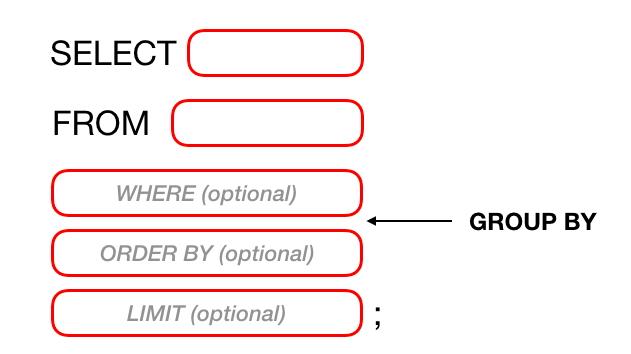

### What is the *total revenue* of per *year*, in *recent* years?

In [ ]:
# recent means 5 years
qry("""
SELECT year, SUM(revenue) AS total_revenue
FROM movies
GROUP BY Year
ORDER BY Year DESC
LIMIT 5
""")

### Which 5 *directors* have had the *most number of movies* earning *over 200M dollars*?

In [ ]:
qry("""
SELECT director, COUNT(title) AS count
FROM movies
WHERE revenue > 200
GROUP BY director
ORDER BY count DESC
limit 5
""")

### Which *three* of the *directors* have the *greatest average rating*?

In [ ]:
qry("""
SELECT director, AVG(rating) AS avg_rating
FROM movies
GROUP BY director
ORDER BY avg_rating DESC
LIMIT 3
""")

Why is the above question maybe not the best to ask?

In [ ]:
# These directors could have made just 1 good movie.

Need filtering BEFORE and AFTER the GROUP operations
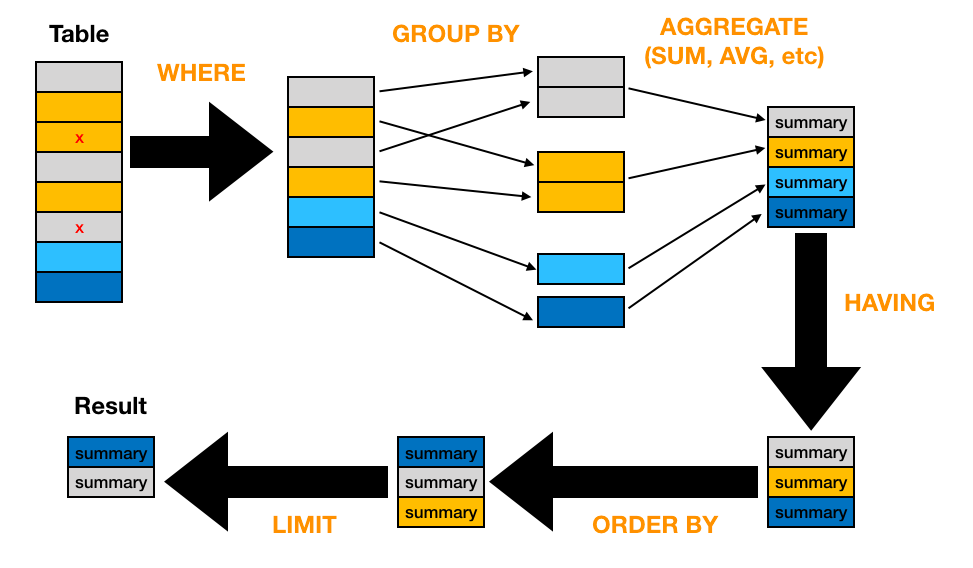

# WHERE vs. HAVING

* WHERE: filter rows in original table
* HAVING: filter groups

### Which five directors *having* at least 3 movies score the *greatest average rating* ?

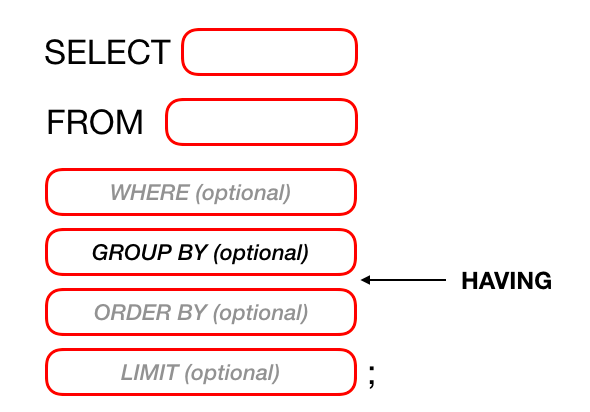

In [ ]:
qry("""
SELECT director, AVG(rating) AS avg_rating, COUNT(*) as count
FROM movies
GROUP BY director
HAVING count >= 3
ORDER BY avg_rating DESC
LIMIT 3
""")

### Which directors have more than 3 movies released since 2010?

In [ ]:
qry("""
SELECT director, COUNT(title) AS count
FROM movies
WHERE year >= 2010
GROUP BY director
HAVING count > 3
""")

### Which *directors* have more than *two* movies with runtimes under *100* minutes

In [ ]:
qry("""
SELECT director, COUNT(title) AS count
FROM movies
WHERE runtime < 100
GROUP BY director
HAVING count > 2
""")

In [ ]:
# Don't forget to close the movies.db connection
c.close()